In [1]:
# Importing some important libraries
import glob
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from ipywidgets import *
import pickle as pk
import sncosmo
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1d
import math
from tabulate import tabulate
#from PTMCMCSampler import PTMCMCSampler
from scipy.integrate import quad
import astropy.units as u
import astropy.constants as const
from scipy.optimize import minimize
import emcee
from astropy.table import Table

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
_SCALE_FACTOR = 1e-12

# phase (x) and wavelength (y)
gridx = np.linspace(-8, 48, 48+8+1, dtype=int) # in days
gridy = np.linspace(3500, 8300, int((8300-3500)/10+1), dtype=int) # in Angstroms

# phase (x) and wavelength (y)
gridx_salt2 = np.linspace(-20, 50, 50+20+1, dtype=int) # in days
gridy_salt2 = np.linspace(2000, 9200, 721, dtype=int) # in Angstroms


# Meshhgrid to show a matplotlib graph 
B1, B2 = np.meshgrid(gridx, gridy, indexing='xy')
# (x, y) grid data
xv = []
yv = []
for i in range(0, len(gridy)):
    for j in range(0, len(gridx)):
        xv.append(gridx[j])
        yv.append(gridy[i])
        
# Our pickles paths
pca_path = './PCA_FA_components/PCA/'
fa_path = './PCA_FA_components/FA/'
# Our SEDs path
surfaces_path = './SEDs_matern/'

%matplotlib inline

In [2]:
pickle_pca_path = glob.glob(pca_path+'*.pkl')

In [3]:
np.random.random(42)
if len(pickle_pca_path)>0:
    print('Loading our pca and fa models...')
    pca = pk.load(open(pca_path+'pca.pkl','rb'))
    fa = pk.load(open(fa_path+'fa.pkl','rb'))
    N_comp = 3
else:
    print('Training our model, please wait...')
    # Here, we use glob to know all .dat files names in the befores path
    file_names = glob.glob(surfaces_path+'*.dat')

    # Data & Data erro in a shape of N X x-Length X y-Length
    data = []
    data_err = []
    for i in range(0, len(file_names)):
        surface = pd.read_csv(file_names[i])
        data.append(np.array(surface['flux']))
        data_err.append(np.array(surface['fluxerr']))

    # Training our model using Principal Component Analysis and Factor Analysis
    # Number of components 
    N_comp = 3
    # Defining a PCA instance and fitting
    pca = PCA(N_comp)
    pca.fit(data)
    # Defining a FA instance and fitting
    fa = FactorAnalysis(N_comp)
    fa.fit(data+data_err)
    
    pk.dump(pca, open(pca_path+'pca.pkl','wb'))
    pk.dump(fa, open(fa_path+'fa.pkl','wb'))
    print('Done!')

Loading our pca and fa models...


/home/joao/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/joao/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator FactorAnalysis from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


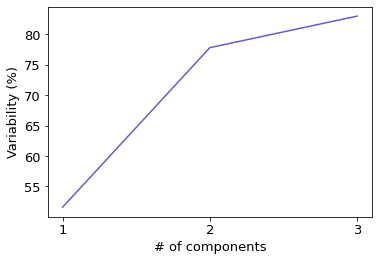

In [4]:
plt.rcParams.update({"font.size": 13})
plt.plot(np.linspace(1, N_comp, N_comp, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('# of components')
plt.ylabel('Variability (%)')
plt.xticks(np.linspace(1, N_comp, N_comp, dtype=int))
#plt.axvline(x=3, color='k', linestyle='--', label='EXP(3)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)
#plt.legend();

In [5]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.829614884207448


/tmp/ipykernel_2901/1119177370.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


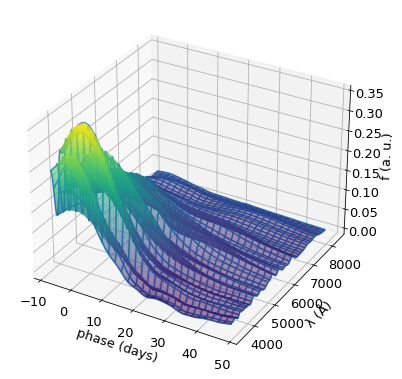

In [6]:
# Mean surface
Z = interp.griddata((xv, yv),pca.mean_,(B1,B2),method='cubic')
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("λ (Å)")
ax.set_zlabel("f (a. u.)")

plt.show()

/tmp/ipykernel_2901/3794753080.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


interactive(children=(Dropdown(description='Component:', options=(0, 1, 3), value=0), Output()), _dom_classes=…

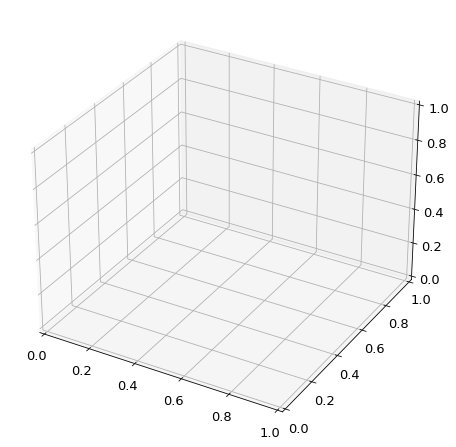

In [7]:
option_list = np.linspace(0, len(fa.components_), len(fa.components_), dtype=int)

#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()
    
    Z = interp.griddata((xv,yv), pca.components_[i], (B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("λ (Å)")
    ax.set_zlabel("f (a. u.)")
    plt.show()
    
i = widgets.Dropdown(options=option_list, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [8]:
M0_salt2 = pd.read_csv("./SALT2_templates/salt2_template_0.dat", names=["time", "wave", "flux"], sep="\s+")
M1_salt2 = pd.read_csv("./SALT2_templates/salt2_template_1.dat", names=["time", "wave", "flux"], sep="\s+")
c = pd.read_csv("./SALT2_templates/salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]
c.head()

,wave,ext
0,3000,4.44356
1,3010,4.35652
2,3020,4.27089
3,3030,4.18667
4,3040,4.10384


In [9]:
M = []
for i in range(0, len(fa.components_)):
    M.append(fa.components_[i].reshape(len(gridy), len(gridx)).T)

In [10]:
HC_ERG_AA

1.9864458571489284e-08

In [11]:
# A new class for sncosmo
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'c']
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0*_SCALE_FACTOR)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1*_SCALE_FACTOR)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2*_SCALE_FACTOR)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3*_SCALE_FACTOR)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4*_SCALE_FACTOR)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5*_SCALE_FACTOR)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6*_SCALE_FACTOR)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7*_SCALE_FACTOR)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8*_SCALE_FACTOR)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9*_SCALE_FACTOR)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        
    def _flux(self, phase, wave):
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))* 10.** (-0.4 * self._model_ext(wave) * c)
   
    def _bandflux_rvar_single(self, band, phase):
        x0 = self._parameters[0]
        x1 = self._parameters[1]
        x2 = self._parameters[2]

        wave, dwave = band.minwave()+(band.maxwave() - band.minwave())/2, 10.
        trans = band(wave) # transmission
        
        m0 = self._model_flux0(phase, wave)
        m1 = self._model_flux1(phase, wave)
        m2 = self._model_flux2(phase, wave)
        tmp = trans * wave
            
        m0int = np.sum(m0 * tmp, axis=1) * dwave/HC_ERG_AA
        m1int = np.sum(m1 * tmp, axis=1) * dwave/HC_ERG_AA
        m2int = np.sum(m2 * tmp, axis=1) * dwave/HC_ERG_AA
        return ((m0int+x1*m1int+x2*m2int)*0.008083732930093502)**2 + (m1int*x0*0.2617690714197349)**2 + (m2int*x0*0.34451843421019135)**2

    # teste
    def bandflux_rcov(self, band, phase):
        diagonal = np.zeros(phase.shape, dtype=np.float64)
        for b in set(band):
            mask = band == b
            diagonal[mask] = self._bandflux_rvar_single(b, phase[mask])
            
        return np.diagflat(diagonal)


In [12]:
lc_fit_table_exp = glob.glob('./cosmo_results/*exp3.dat')
#lc_fit_table_exp = []

In [13]:
lc_fit_table_exp

['./cosmo_results/matern_fit_exp3.dat']

In [14]:
table_exp3 = []

In [15]:
files = glob.glob('./JLA/*.list')
print("JLA files in path: ", len(files))

JLA files in path:  740


In [16]:
outliers_filters = {}
for i in range(0, len(files)):
    data = sncosmo.read_lc(files[i], format='salt2')
    sn_name = data.meta['SN']
    data_df = data.to_pandas()
    unique_filters = data_df['Filter'].unique()
    outliers_filters[str(sn_name)] = []
    for j in range(0, len(unique_filters)):
        if data["Filter"][0][:-3] == "MEGACAMPSF":
            r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)
            megacg = sncosmo.get_bandpass('megacampsf::g', r)
            megacr = sncosmo.get_bandpass('megacampsf::r', r)
            megaci = sncosmo.get_bandpass('megacampsf::i', r)
            megacz = sncosmo.get_bandpass('megacampsf::z', r)

            sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
            sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
            sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
            sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)
            
        bandpass = sncosmo.get_bandpass(unique_filters[j])
        min_wave = bandpass.minwave()
        max_wave = bandpass.maxwave()
        if min_wave < min(gridy)*(1+data.meta['Z_HELIO']) or max_wave > max(gridy)*(1+data.meta['Z_HELIO']):
            outliers_filters[str(sn_name)].append(unique_filters[j])

In [17]:
data.meta['Z_HELIO']

0.0139

In [18]:
outliers = [19, 106, 107, 201, 367, 714]

In [19]:
if len(lc_fit_table_exp) > 0:
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/matern_fit_exp3.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv','cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])
else:
    print('Applying fits to our SNe')
    exp_lc = EXP_LC(gridx, gridy, M[0], M[1], M[2], M[2], M[2], M[2], M[2], M[2], M[2], M[2], c) # change to M[2] to other orders SEDs
    files = glob.glob('./JLA/*.list')
    print("JLA files in path: ", len(files))

    for i in range(714, len(files)):
        print(i)
        if i not in outliers:
            data = sncosmo.read_lc(files[i], format='salt2')
            data_df = data.to_pandas()
            
            if str(data.meta['SN']) in outliers_filters.keys():
                for k in range(0, len(outliers_filters[str(data.meta['SN'])])):
                    #print(outliers_filters[str(data.meta['SN'])][k])
                    data_df = data_df[data_df['Filter']!=outliers_filters[str(data.meta['SN'])][k]]
            data_df.reset_index(inplace=True)
            #print('tamanho do dataset:',len(data_df))
            if data["Filter"][0][:-3] == "MEGACAMPSF":
                r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)
                megacg = sncosmo.get_bandpass('megacampsf::g', r)
                megacr = sncosmo.get_bandpass('megacampsf::r', r)
                megaci = sncosmo.get_bandpass('megacampsf::i', r)
                megacz = sncosmo.get_bandpass('megacampsf::z', r)

                sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
                sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
                sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
                sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)

            snname = data.meta['SN']
            #print(snname)
            exp3 = sncosmo.Model(source=exp_lc,
                                 effects=[sncosmo.F99Dust()],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])

            exp3.set(mwebv=data.meta['MWEBV'],
                    z = data.meta['Z_HELIO'],
                    x3 = 0,
                    x4 = 0,
                    x5 = 0,
                    x6 = 0,
                    x7 = 0,
                    x8 = 0,
                    x9 = 0,
                    c = 0)

            result_exp3, m_exp3 = sncosmo.fit_lc(Table.from_pandas(data_df), exp3, ['t0', 'x0', 'x1', 'x2'], modelcov=True, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)

            if result_exp3.success == True:
                if result_exp3.ndof > 2:
                    print(result_exp3.chisq/result_exp3.ndof)
                    table_exp3.append((snname, result_exp3.parameters[0], result_exp3.parameters[1], result_exp3.errors['t0'], result_exp3.parameters[2], result_exp3.errors['x0'], result_exp3.parameters[3], result_exp3.errors['x1'], result_exp3.parameters[4], result_exp3.errors['x2'], data.meta['MWEBV'], result_exp3.covariance[1][2], result_exp3.covariance[1][3], result_exp3.covariance[2][3], result_exp3.chisq/result_exp3.ndof, "exp3"))

    save_path = './cosmo_results/'
    completeName = os.path.join(save_path,'matern_fit_exp3.dat')
    f = open(completeName, 'w')        
    f.write(tabulate(table_exp3, tablefmt='plain'))
    f.close()
    
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/matern_fit_exp3.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv', 'cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])


Loading our light curve parameters...


In [20]:
lc_fit_table_SALT2 = glob.glob('./cosmo_results/*salt2_with_cuts.dat')
#lc_fit_table_exp = []

In [21]:
table_SALT2 = []

In [22]:
outliers_SALT2 = [19, 106, 107, 201, 367, 611, 714]

In [23]:
if len(lc_fit_table_SALT2) > 0:
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/salt2_with_cuts.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv','cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])
else:
    print('Applying fits to our SNe')
    exp_lc = EXP_LC(gridx, gridy, M[0], M[1], M[2], M[2], M[2], M[2], M[2], M[2], M[2], M[2], c) # change to M[2] to other orders SEDs
    files = glob.glob('./JLA/*.list')
    print("JLA files in path: ", len(files))

    for i in range(611, len(files)):
        print(i)
        if i not in outliers_SALT2:
            data = sncosmo.read_lc(files[i], format='salt2')
            data_df = data.to_pandas()
            
            if str(data.meta['SN']) in outliers_filters.keys():
                for k in range(0, len(outliers_filters[str(data.meta['SN'])])):
                    #print(outliers_filters[str(data.meta['SN'])][k])
                    data_df = data_df[data_df['Filter']!=outliers_filters[str(data.meta['SN'])][k]]
            data_df.reset_index(inplace=True)
            #print('tamanho do dataset:',len(data_df))
            if data["Filter"][0][:-3] == "MEGACAMPSF":
                r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)
                megacg = sncosmo.get_bandpass('megacampsf::g', r)
                megacr = sncosmo.get_bandpass('megacampsf::r', r)
                megaci = sncosmo.get_bandpass('megacampsf::i', r)
                megacz = sncosmo.get_bandpass('megacampsf::z', r)

                sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
                sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
                sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
                sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)

            snname = data.meta['SN']
            #print(snname)
            salt2 = sncosmo.Model(source='salt2',
                                 effects=[sncosmo.F99Dust()],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])

            salt2.set(mwebv=data.meta['MWEBV'],
                    z = data.meta['Z_HELIO'])

            result_salt2, m_salt2 = sncosmo.fit_lc(Table.from_pandas(data_df), salt2, ['t0', 'x0', 'x1', 'c'], modelcov=True, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)

            if result_salt2.success == True:
                if result_salt2.ndof > 2:
                    print(result_salt2.chisq/result_salt2.ndof)
                    table_SALT2.append((snname, result_salt2.parameters[0], result_salt2.parameters[1], result_salt2.errors['t0'], result_salt2.parameters[2], result_salt2.errors['x0'], result_salt2.parameters[3], result_salt2.errors['x1'], result_salt2.parameters[4], result_salt2.errors['c'], data.meta['MWEBV'], result_salt2.covariance[1][2], result_salt2.covariance[1][3], result_salt2.covariance[2][3], result_salt2.chisq/result_salt2.ndof, "salt2"))

    save_path = './cosmo_results/'
    completeName = os.path.join(save_path,'salt2_with_cuts.dat')
    f = open(completeName, 'w')        
    f.write(tabulate(table_SALT2, tablefmt='plain'))
    f.close()
    
    print('Loading our light curve parameters...')
    salt2_fit = pd.read_csv('./cosmo_results/salt2_with_cuts.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'c', 'c_err', 'mwebv', 'cov_x0x1', 'cov_x0c', 'cov_x1c', 'chiquad/dof', 'model'])


Loading our light curve parameters...


In [24]:
len(exp3_fit['chiquad/dof'][exp3_fit['chiquad/dof']<5.])

688

### exp cuts

In [25]:
exp3_fit = exp3_fit[exp3_fit['chiquad/dof']<5.]

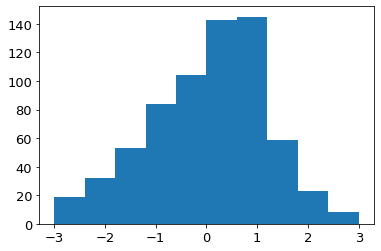

In [26]:
plt.hist(exp3_fit['x1'], range=(-3, 3));

In [27]:
exp3_fit = exp3_fit[np.abs(exp3_fit['x1'])<3.]
len(exp3_fit)

670

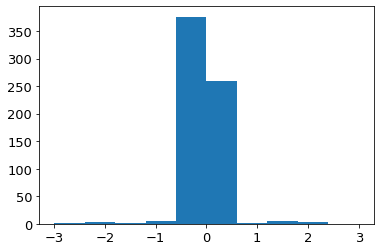

In [28]:
plt.hist(exp3_fit['x2'], range=(-3, 3));

In [29]:
exp3_fit = exp3_fit[np.abs(exp3_fit['x2'])<3.]
len(exp3_fit)

656

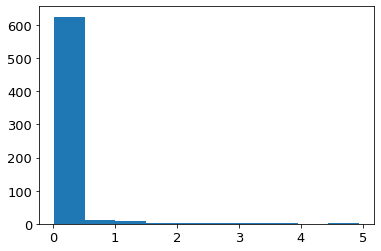

In [30]:
plt.hist(exp3_fit['x2_err']);

In [31]:
np.min(exp3_fit['x2_err'])

0.0186128

In [32]:
exp3_fit.reset_index(drop=True, inplace=True)

In [33]:
exp3_fit["mb"]= -2.5*np.log10(exp3_fit["x0"])+10 #referencia
exp3_fit["mb_err"] = 1.08574*(exp3_fit["x0_err"])/exp3_fit["x0"]

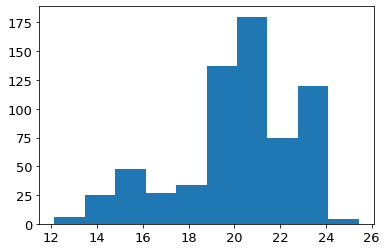

In [34]:
plt.hist(exp3_fit['mb']);

In [35]:
min(exp3_fit['mb'])

12.137980908693832

### salt2 cuts

In [36]:
print('Loading our light curve parameters...')
salt2_fit = pd.read_csv('./cosmo_results/fit_salt2.dat',
                       sep='\s+',
                       names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'c', 'c_err', 'mwebv', 'cov_x0x1', 'cov_x0c', 'cov_x1c', 'chiquad/dof', 'model'])


Loading our light curve parameters...


In [37]:
salt2_fit.drop(salt2_fit.index[salt2_fit["chiquad/dof"]>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["x1"])>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["c"])>2], axis=0, inplace=True)

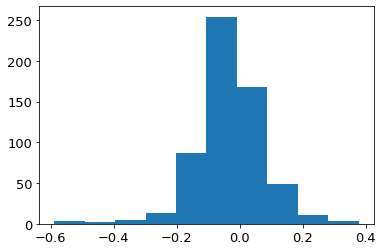

In [38]:
plt.hist(salt2_fit['c']);

In [39]:
salt2_fit["mb"]= -2.5*np.log10(salt2_fit["x0"])+10 #referencia
salt2_fit["mb_err"] = 1.08574*(salt2_fit["x0_err"])/salt2_fit["x0"]

In [40]:
salt2_fit.reset_index(drop=True, inplace=True)

In [41]:
salt2_fit

,name,redshift,t0,t0_err,x0,x0_err,x1,x1_err,c,c_err,mwebv,cov_x0x1,cov_x0c,cov_x1c,chiquad/dof,model,mb,mb_err
0,03D1au,0.504300,52909.7,0.184387,1.135650e-05,8.286350e-08,1.292900,0.134236,-0.020352,0.012490,0.0296,-6.719740e-09,-2.978810e-10,-0.000203,1.02367,salt2,22.361889,0.007922
1,03D1aw,0.582000,52898.4,1.978770,6.986800e-06,1.725990e-07,2.224940,0.707499,-0.007330,0.025483,0.0252,6.354680e-08,-8.085340e-10,0.006636,1.40655,salt2,22.889304,0.026822
2,03D1ax,0.496000,52916.1,0.101686,1.144130e-05,9.210410e-08,-0.840369,0.104929,-0.030900,0.013322,0.0264,-5.879210e-09,-4.059190e-10,-0.000103,2.01389,salt2,22.353812,0.008740
3,03D1co,0.679000,52954.4,0.451643,4.168300e-06,1.590080e-07,0.769722,0.522152,-0.033253,0.042096,0.0299,-7.236470e-08,-1.714290e-09,0.008467,1.37515,salt2,23.450103,0.041418
4,03D1dt,0.612000,52962.7,0.770711,8.794270e-06,2.511610e-07,-2.645760,2.483630,-0.111281,0.049271,0.0279,-5.606780e-07,-9.591460e-09,0.100906,1.57660,salt2,22.639501,0.031008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,sn2007ae,0.064388,54153.5,0.438483,1.417640e-03,2.613910e-05,1.282060,0.176220,-0.040879,0.009799,0.0450,1.424060e-06,-1.643020e-07,0.000120,1.85156,salt2,17.121085,0.020019
592,sn2007bc,0.020771,54200.5,0.104422,7.666070e-03,6.610020e-05,-1.165970,0.046793,0.023142,0.006560,0.0220,-6.864340e-07,-3.105460e-07,0.000008,2.75907,salt2,15.288568,0.009362
593,sn2007bd,0.031018,54206.2,0.056564,4.285290e-03,1.689450e-05,-1.233270,0.041920,-0.066050,0.003382,0.0340,-1.765370e-07,-4.349510e-08,0.000013,2.77554,salt2,15.920049,0.004280
594,sn2007f,0.023590,54124.0,0.032918,7.870480e-03,3.157010e-05,0.628372,0.026171,-0.034816,0.002843,0.0170,-4.331480e-07,-7.419510e-08,0.000016,2.89571,salt2,15.259997,0.004355


In [42]:
class make_cosmo:
    def __init__(self, data):
        """
        calculates a chi squared function depending on the model
        data: pd dataframe
        """
        self.data = data
        
    def integrando_dl(self, x, Om_m, Om_l):
        '''
        cmb redshift = x
        Omega matter density = Om_m
        Omega cosmologic constant density = Om_l

        :return = integrand
        '''
        return (1/(np.sqrt(Om_m*(1 + x)*(1 + x)*(1 + x) + Om_l + (1.0 - Om_m - Om_l)*(1 + x)*(1 + x))))
    
    #test function for luminosity distance
    def luminosity_d(self, Om_k, integral):
        '''
        Omega curvature density = Om_k
        Integral value = integral

        :return = luminosity distance/(1+redshift)
        '''
        if(Om_k > 0):
            result = (1/np.sqrt(Om_k))*np.sinh(np.sqrt(Om_k)*integral)
        if(Om_k == 0):
            result = integral
        if(Om_k < 0):
            result = (1/np.sqrt(-Om_k))*np.sin(np.sqrt(-Om_k)*integral)

        return result
    
    def lnpriorfn_exp3(self, par):
        if -22. < par[0] < -19. and 0. < par[1] < 1. and -1. < par [2] < 0. and  0.1 < par[3] < 1. and .1 < par[4] < 1. and  .0 < par[5] < 1.0:
            return 0.
        else:
            return -np.inf  
        
    def model(self, par):
        """
        chi squared function of exp3
        par: list/np array (free parameters)
        """
        [M, a, b, Om_m, Om_l, h] = par
        #curvature density  
        Om_k = 1.0 - float(Om_m) - float(Om_l)

        muth = np.zeros(len(self.data))
        #print(M, a, b, Om_m, Om_l)
        #to calculate luminosity distance with Om_m and Om_l as arguments
        for ii in range(0, len(self.data)):
            #integral value
            I = quad(self.integrando_dl, 0, self.data["redshift"][ii], args = (Om_m, Om_l))
            #luminosity distance
            dl = (1 + self.data["redshift"][ii])*self.luminosity_d(Om_k, I[0])
            #theoric distance module
            muth[ii] = 5*np.log10(dl) - 5*np.log10(h) + 42.3856062736
            
        muexp = self.data["mb"] - M - 2.5*np.log10(1 - self.data["x1"]*a - self.data["x2"]*b)  
        
        #cov_err = 2*1.08574*a*b*self.data["cov_x1x2"]/(1-a*self.data["x1"]-b*self.data["x2"])**2
        E_muexp_quad = self.data["mb_err"]*self.data["mb_err"] + ((1.08574*a/(1-a*self.data["x1"] - b*self.data["x2"]))*self.data["x1_err"])**2 + ((1.08574*b/(1-a*self.data["x1"] + b*self.data["x2"]))*self.data["x2_err"])**2
        
        chi_squared = np.sum(((muexp - muth)**2)/E_muexp_quad)
        log_part = np.sum(np.log(E_muexp_quad))
        chi_total = chi_squared + log_part + len(E_muexp_quad)*2*np.pi + len(self.data)*2*np.pi
        return -chi_total
    
    def log_probability_exp3(self, par):
        lp = self.lnpriorfn_exp3(par)
        if not np.isfinite(lp):
            return -np.inf
        else:
            return lp + self.model(par)
    
    def lnpriorfn_salt2(self, par):
        if -22. < par[0] < -19. and 0. < par[1] < 1. and 0. < par [2] < 5. and  0.1 < par[3] < 1. and .1 < par[4] < 1. and  .0 < par[5] < 1.0:
            return 0.
        else:
            return -np.inf 
    
    def model_salt2(self, par):
        """
        chi squared function of salt2
        par: list/np array (free parameters)
        """
        [M, a, b, Om_m, Om_l, h] = par
        
        #curvature density  
        Om_k = 1.0 - float(Om_m) - float(Om_l)

        muth = np.zeros(len(self.data))
        #print(M, a, b, Om_m, Om_l)
        #to calculate luminosity distance with Om_m and Om_l as arguments
        for ii in range(0, len(self.data)):

            #integral value

            I = quad(self.integrando_dl, 0, self.data["redshift"][ii], args = (Om_m, Om_l))

            #luminosity distance
            dl = (1 + self.data["redshift"][ii])*self.luminosity_d(Om_k, I[0])

            #theoric distance module
            
            muth[ii] = 5*np.log10(dl) - 5*np.log10(h) + 42.3856062736
        
        #experimental distance module array
        muexp = self.data["mb"] - M + a*self.data["x1"] - b*self.data["c"]   
        #cov_err = +(2*2.5/self.data["x0"]*np.log(10))*a*self.data["cov_x0x1"] - (2*2.5/self.data["x0"]*np.log(10))*b*self.data["cov_x0c"] - 2*a*b*self.data["cov_x1c"]

        E_muexp_quad = self.data["mb_err"]*self.data["mb_err"] + a*a*self.data["x1_err"]*self.data["x1_err"] + b*b*self.data["c_err"]*self.data["c_err"]

        chi_squared = np.sum(((muexp - muth)**2)/E_muexp_quad)

        log_part = np.sum(np.log(E_muexp_quad))
        chi_total = chi_squared + log_part + len(E_muexp_quad)*2*np.pi  + len(self.data)*2*np.pi
        return -chi_total    
    
    def log_probability_salt2(self, par):
        lp = self.lnpriorfn_salt2(par)
        if not np.isfinite(lp):
            return -np.inf
        else:
            return lp + self.model_salt2(par)

In [43]:
#cosmo = make_cosmo(exp3_fit)

In [44]:
#x0 = [-21.04, 0.62, 3, 0.37, 0.7, 0.7, 2.]
#res = minimize(cosmo.model, x0, method='Nelder-Mead', tol=1e-6)
#res.x

## MCMC Different models

* EXP(3)

In [45]:
ndim=6
nwalkers=30

In [46]:
cosmo = make_cosmo(exp3_fit)

In [47]:
x0 = np.array([-20.79397346, 0.63849491, -0.36565018, 0.37389424, 0.7163119 , 0.67142361])

In [48]:
sampler_exp3 = emcee.EnsembleSampler(nwalkers, ndim, cosmo.log_probability_exp3, threads=6)

In [49]:
p0 = x0+0.1*np.random.randn(nwalkers, ndim)

In [50]:
state_exp3 = sampler_exp3.run_mcmc(p0, 200)

sampler_exp3.reset()

/home/joao/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [51]:
sampler_exp3.run_mcmc(state_exp3, 500);

(array([4.555e+03, 6.280e+03, 3.278e+03, 5.440e+02, 3.000e+01, 8.000e+00,
        0.000e+00, 6.000e+00, 1.200e+01, 2.870e+02]),
 array([0.1001865 , 0.16194756, 0.22370861, 0.28546966, 0.34723071,
        0.40899176, 0.47075282, 0.53251387, 0.59427492, 0.65603597,
        0.71779702]),
 [<matplotlib.patches.Polygon at 0x7f702b24ed60>])

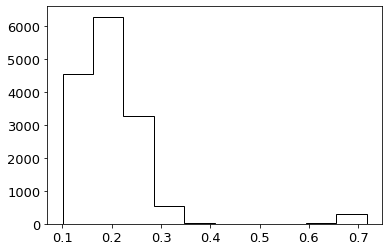

In [52]:
samples_exp3 = sampler_exp3.get_chain(flat=True)
plt.hist(samples_exp3[:, 3], color="k", histtype="step")

In [53]:
exp3_chain = pd.DataFrame(samples_exp3, columns=['M', 'a', 'b', 'om_m', 'om_l', 'h'])
exp3_chain.head()

,M,a,b,om_m,om_l,h
0,-19.848325,0.153013,-0.993231,0.152356,0.422055,0.660462
1,-19.907146,0.142504,-0.999415,0.109799,0.362671,0.639255
2,-20.160591,0.154388,-0.987752,0.258212,0.622295,0.575769
3,-20.062466,0.444003,-0.988433,0.380040,0.633714,0.662076
4,-20.206922,0.153972,-0.995700,0.306590,0.652614,0.562861


(array([ 702., 2492., 3992., 3997., 2217., 1042.,  231.,   22.,    4.,
         301.]),
 array([0.32649079, 0.3754702 , 0.42444961, 0.47342902, 0.52240843,
        0.57138785, 0.62036726, 0.66934667, 0.71832608, 0.76730549,
        0.8162849 ]),
 <BarContainer object of 10 artists>)

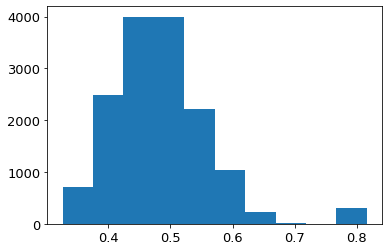

In [54]:
plt.hist(exp3_chain['om_l'])

In [55]:
exp3_chain.to_csv('./chains/chains_exp3/exp3_chain.csv')

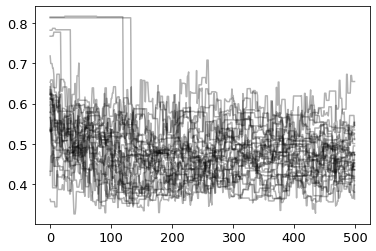

In [56]:
plt.plot(sampler_exp3.chain[:,:,4].T, '-', color='k', alpha=0.3);

* mcmc salt2

In [57]:
cosmo = make_cosmo(salt2_fit)

In [58]:
x0 = np.array([-20.91599244,   0.65133993,   3.01318986,   0.37133276, 0.70184364,   0.69873388])

In [59]:
sampler_salt2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo.log_probability_salt2, threads=6)

In [60]:
p0 = x0+0.2*np.random.randn(nwalkers, ndim)

In [61]:
state_salt2 = sampler_salt2.run_mcmc(p0, 200)
sampler_salt2.reset()

/home/joao/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [62]:
sampler_salt2.run_mcmc(state_salt2, 500);

In [63]:
tau = sampler_salt2.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [49.92930072 35.58372234 38.33829321 33.54558148 36.22571904 50.19318735]

In [64]:
flat_samples = sampler_salt2.get_chain(discard=100, thin=10, flat=True)
print(flat_samples.shape)

(1200, 6)


(array([ 241., 1183., 1974., 2565., 2629., 2169., 2324., 1353.,  467.,
          95.]),
 array([0.38035599, 0.39517449, 0.40999299, 0.42481149, 0.43962999,
        0.45444849, 0.46926699, 0.48408549, 0.49890399, 0.51372249,
        0.52854099]),
 [<matplotlib.patches.Polygon at 0x7f708c075ee0>])

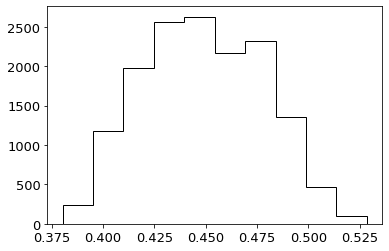

In [65]:
samples_salt2 = sampler_salt2.get_chain(flat=True)
plt.hist(samples_salt2[:, 5], color="k", histtype="step")

(array([  3.,  30.,  72., 157., 319., 325., 191.,  70.,  30.,   3.]),
 array([0.57580905, 0.60800702, 0.64020499, 0.67240296, 0.70460094,
        0.73679891, 0.76899688, 0.80119485, 0.83339282, 0.8655908 ,
        0.89778877]),
 <BarContainer object of 10 artists>)

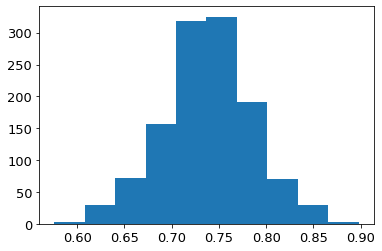

In [66]:
plt.hist(flat_samples.T[4])

In [67]:
salt2_chain = pd.DataFrame(samples_salt2, columns=['M', 'a', 'b', 'om_m', 'om_l', 'h'])
salt2_chain.head()

,M,a,b,om_m,om_l,h
0,-20.564517,0.158339,3.161984,0.321795,0.808277,0.478200
1,-20.670003,0.153400,3.183349,0.315035,0.781505,0.455012
2,-20.598952,0.155873,3.168708,0.395880,0.867519,0.470158
3,-20.661202,0.153130,3.144912,0.347302,0.834933,0.457651
4,-20.562525,0.156610,3.189797,0.386623,0.862889,0.478551


In [68]:
salt2_chain.to_csv('./chains/chains_salt2/salt2_chain.csv')

In [69]:
salt2_chain

,M,a,b,om_m,om_l,h
0,-20.564517,0.158339,3.161984,0.321795,0.808277,0.478200
1,-20.670003,0.153400,3.183349,0.315035,0.781505,0.455012
2,-20.598952,0.155873,3.168708,0.395880,0.867519,0.470158
3,-20.661202,0.153130,3.144912,0.347302,0.834933,0.457651
4,-20.562525,0.156610,3.189797,0.386623,0.862889,0.478551
...,...,...,...,...,...,...
14995,-20.490133,0.155158,3.174050,0.332650,0.787894,0.493968
14996,-20.720396,0.152888,3.177553,0.289697,0.732854,0.444080
14997,-20.678805,0.154852,3.120639,0.325976,0.774049,0.452508
14998,-20.966458,0.154678,3.139499,0.268378,0.705174,0.396329


* Chains analysis 

In [70]:
exp3_chain = pd.read_csv('./chains/chains_exp3/exp3_chain.csv')

In [71]:
salt2_chain = pd.read_csv('./chains/chains_salt2/salt2_chain.csv')

In [72]:
histogramsN = ['M', 'a', 'b', 'Om_m', 'Om_l', 'h']
latexN  = ['M', 'alpha', 'beta', '\Omega_m', '\Omega_\Lambda', 'h']

In [73]:
chain_1 = []
for i in range(0, len(exp3_chain)):
    if i > 0:
        chain_1.append([exp3_chain["M"][i], exp3_chain["a"][i], exp3_chain["b"][i], exp3_chain["om_m"][i], exp3_chain["om_l"][i], exp3_chain["h"][i]])

In [74]:
chain_2 = []
for i in range(0, len(salt2_chain)):
    if i > 0:
        chain_2.append([salt2_chain["M"][i], salt2_chain["a"][i], salt2_chain["b"][i], salt2_chain["om_m"][i], salt2_chain["om_l"][i], salt2_chain["h"][i]])

In [75]:
chain_1 = np.array(chain_1)
chain_2 = np.array(chain_2)

In [76]:
from getdist import plots, MCSamples

ModuleNotFoundError: No module named 'getdist'

In [77]:
samples_1 = MCSamples(samples=chain_1, names = histogramsN, labels = latexN)
samples_2 = MCSamples(samples=chain_2, names = histogramsN, labels = latexN)

NameError: name 'MCSamples' is not defined

In [78]:
plt.rcParams.update({"font.size": 15})
g = plots.get_single_plotter(rc_sizes=True)

samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
g.settings.alpha_filled_add = 0.7

g.settings.num_plot_contours = 2
g.plot_2d([samples_1, samples_2], 'Om_m', 'Om_l',
          filled=True,
          line_args=[{'lw':1, 'color':'slateblue'}, {'lw':2, 'color':'C3'}],
          contour_colors=['C3','slateblue'])
g.add_legend(['exp(3)', 'salt2'], legend_loc='lower right')
plt.subplots_adjust(bottom=0.15)
#plt.xlim(0, 0.8)
#plt.ylim(0, 1.2)
#plt.savefig("/home/joao/Desktop/curvas_confianca.png", dpi = 200); #g.plot_2d(samplessalt2, 'Om_m', 'Om_l');

NameError: name 'plots' is not defined

(array([0.95550352, 3.39190139, 5.43357559, 5.44038117, 3.01759446,
        1.41828301, 0.31441783, 0.02994455, 0.00544446, 0.40969595]),
 array([0.32649079, 0.3754702 , 0.42444961, 0.47342902, 0.52240843,
        0.57138785, 0.62036726, 0.66934667, 0.71832608, 0.76730549,
        0.8162849 ]),
 <BarContainer object of 10 artists>)

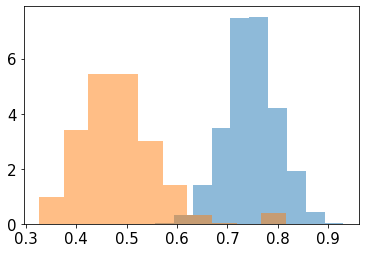

In [79]:
plt.hist(salt2_chain['om_l'], alpha=0.5, density=True)
plt.hist(exp3_chain['om_l'], alpha=0.5, density=True)

In [80]:
import corner

In [81]:
exp3 = np.array([samples_exp3.T[3], samples_exp3.T[4]])
salt2 = np.array([samples_salt2.T[3], samples_salt2.T[4]])

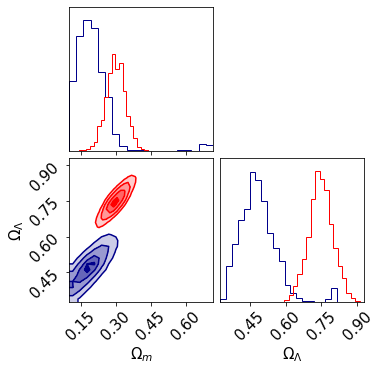

In [82]:
figure = corner.corner(exp3.T, color='darkblue', smooth=True, plot_density=False, plot_datapoints=False, show_titles=False, fill_contours=True, labels=['$\Omega_m$', '$\Omega_\Lambda$'])
corner.corner(salt2.T,fig=figure, color='r', smooth=True, plot_density=False, plot_datapoints=False, show_titles=False, fill_contours=True, labels=['$\Omega_m$', '$\Omega_\Lambda$']);

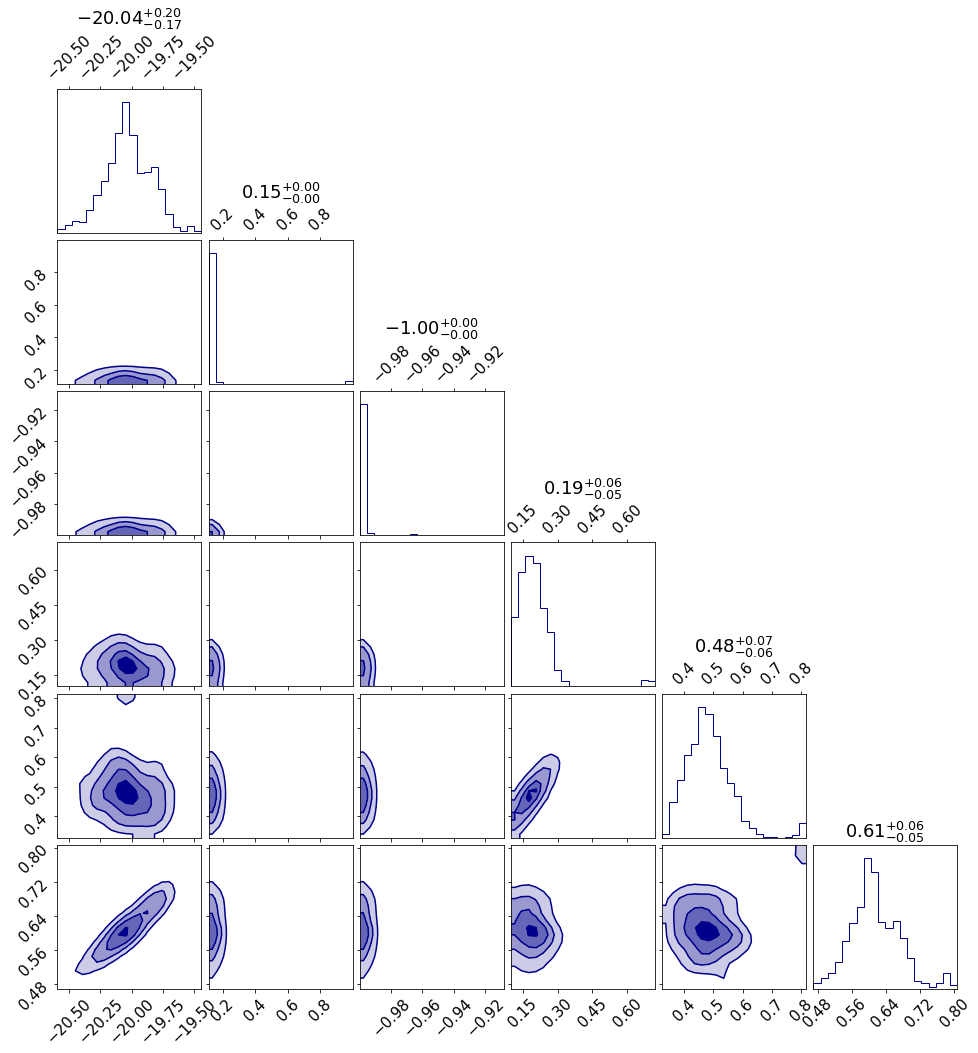

In [83]:
figure = corner.corner(samples_exp3, color='darkblue', smooth=True, plot_density=False, plot_datapoints=False, show_titles=True, fill_contours=True, top_ticks=True);

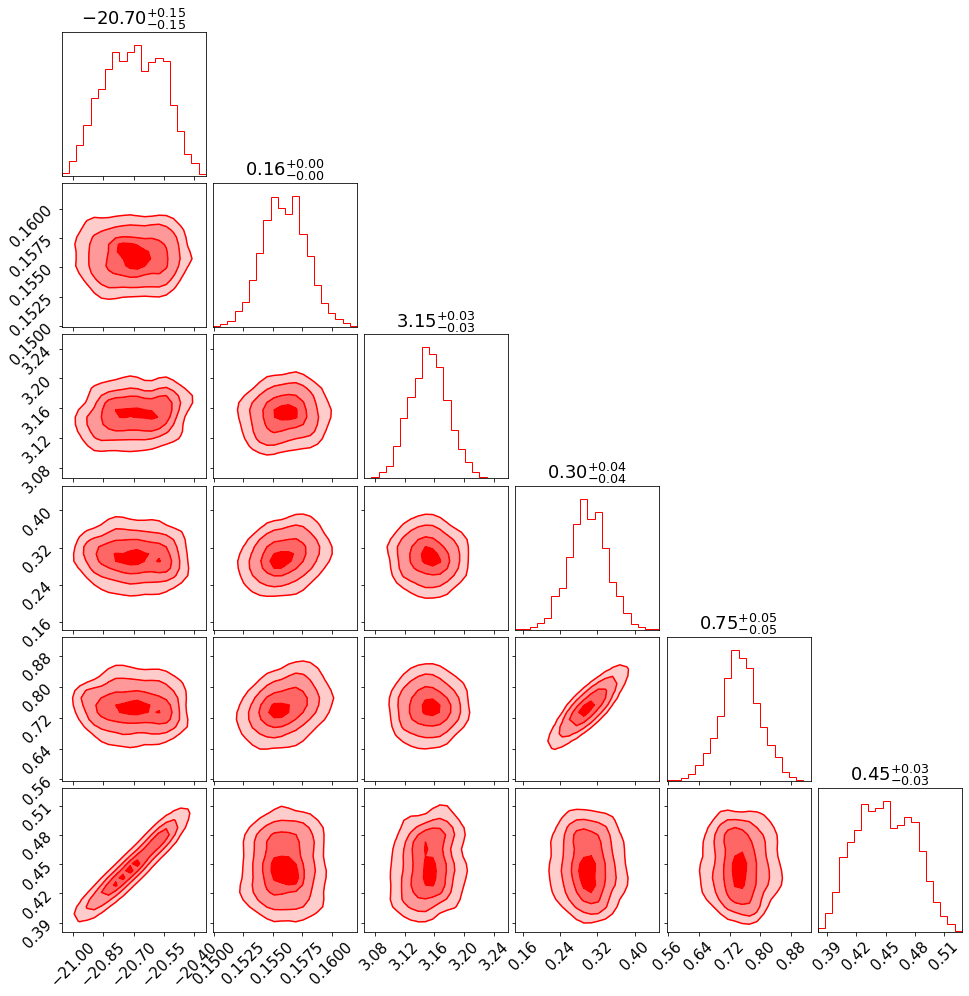

In [84]:
figure = corner.corner(samples_salt2, color='r', smooth=True, plot_density=False, plot_datapoints=False, show_titles=True, fill_contours=True)

In [85]:
exp3_chain

,Unnamed: 0,M,a,b,om_m,om_l,h
0,0,-19.848325,0.153013,-0.993231,0.152356,0.422055,0.660462
1,1,-19.907146,0.142504,-0.999415,0.109799,0.362671,0.639255
2,2,-20.160591,0.154388,-0.987752,0.258212,0.622295,0.575769
3,3,-20.062466,0.444003,-0.988433,0.380040,0.633714,0.662076
4,4,-20.206922,0.153972,-0.995700,0.306590,0.652614,0.562861
...,...,...,...,...,...,...,...
14995,14995,-20.124689,0.147502,-0.999813,0.100690,0.380250,0.581601
14996,14996,-20.096285,0.141917,-0.999508,0.218783,0.510455,0.590234
14997,14997,-20.463373,0.150140,-0.999984,0.132008,0.436658,0.498174
14998,14998,-19.724637,0.147909,-0.998827,0.186718,0.473530,0.700276
